### **Problem Statement**: The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

## SETUP

In [51]:
# To ensure Python ≥ 3.5 is used
import sys
assert sys.version_info >= (3, 5)

#Check if it is running in Kaggle or Colab
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

#Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

#common imports
import numpy as np
import os


#for uniformity in output
np.random.seed(42)


#for our plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)


#Where we save our figures
PROJECT_ROOT_DIR = "."
#CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


#To handle saving of the figures
def save_fig(fig_id, tight_layout=True, fig_extension ="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [52]:
##Fetch the data and load it

import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"


def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)
            
fetch_titanic_data()

In [53]:
#loading the dataset

import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [54]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

The data is already split into a training set and a test set. However, the test data does *not* contain the labels: your goal is to train the best model you can using the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

Let's take a peek at the top few rows of the training set:

In [55]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


A description of the attributes  is as follows:

* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

### Having a Top Level look at the Data


In [56]:
#The PassengerId is a unique enough ID for the DataFrame

train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [57]:
#We would have a look at how much data is missing
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [58]:
#Let's get the percentage of the missing values

print("Cabin has " + str((100 -(204/891) * 100)) + "% of missing values\n")

print("Age has " + str((100 -(714/891) * 100)) + "% of missing values\n")

print("Embarked has " + str((100 -(889/891) * 100)) + "% of missing values\n")

Cabin has 77.10437710437711% of missing values

Age has 19.86531986531986% of missing values

Embarked has 0.22446689113355944% of missing values



From this we can see that **Age**, **Cabin** and **Embarked** have some missing data. Cabin has the most missing values, we would ignore it for now. I could replace the null values with a median age or for aa smarter implementation we could predict the age based on the other columns  (for example, the median age is 37 in 1st class, 29 in 2nd class and 24 in 3rd class). Let's use the first approach for now

In [59]:
#Let's get some insight on the data

train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Insights

1. About 38% of people survuved. THis is less than 40% so we can use accuracy as a useful metric to evaluate the model
2. The mean **Age** was less than 30 years old

In [60]:
#Let us get an idea of how our target is

train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Our target is indeed 0 or 1

We would check other categorical attributes in the next few lines

In [61]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [62]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [63]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

### Our Preprocessing Pipeline

In [64]:
#We would create a numerical pipeline first
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [65]:
#Then the pipeline for the categorical attribs

from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse=False)),
])

In [66]:
#Then joining both pipelines

from sklearn.compose import ColumnTransformer


num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])


This Pipeline takes in the raw data and outputs numerical input features that we can feed to any Machine Learning model

In [67]:
#We would run the preprocessing pipeline on the training set

X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])

X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [68]:
#Let us extract our Labels

y_train = train_data["Survived"]

We're ready to try different models now

1. Random Forest Classifier

In [69]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [70]:
#Now let's use the trained model to make a prediction on the test set
#We transform the test set first
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])

#Thed we make the prediction
y_pred = forest_clf.predict(X_test)


In [71]:
#Let's Cross Validate our model

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)

#and then get the mean of the scores
forest_scores.mean()

0.8160637271592328

This is a Kaggle competition so you can upload a CSV file containing the oredictions (You can check the requirements page)

The leaderboard for the Titanic Competition on Kaggle, this score makes us around the top 2%

you can easily find the [list of victims](https://www.encyclopedia-titanica.org/titanic-victims/) of the Titanic

In [72]:
#Trying a SVC model

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8260637271592328

So this model scores better

Let's get more info other than the mean score. We would plot the IQR using Boxplots. 
Let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores. Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

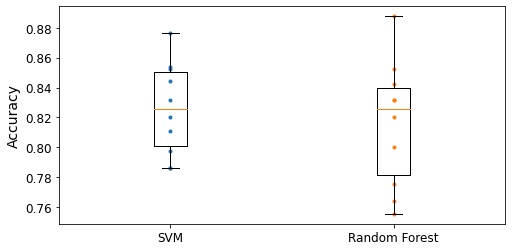

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

The random forest classifier got a very high score on one of the 10 folds, but overall it had a lower mean score, as well as a bigger spread, so it looks like the SVM classifier is more likely to generalize well.

To improve this result further, we could:
* Compare many more models and tune hyperparameters using cross validation and grid search,
* Do more feature engineering, for example:
  * Try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).
  * Replace **SibSp** and **Parch** with their sum.
  * Try to identify parts of names that correlate well with the **Survived** attribute.
  * Use the **Cabin** column, for example take its first letter and treat it as a categorical attribute.

Out of the above suggestions to improve our model, I will do the following:
* Tune hyperparameters using cross validation and grid search,
* Do more feature engineering, for example:
  * Try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age.
  * have a special category for people traveling alone since only 30% of them survived (see below).
  * Replace **SibSp** and **Parch** with their sum.

1. convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).

In [74]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15  #We use the floor operator to create the numerical categories
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


2. Replace **SibSp** and **Parch** with their sum. We would call this feature "RelativesOnboard"

In [75]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


3. Special Category for people travelling alone.  We would call this "Alone"

In [76]:
train_data["Alone"] = train_data["RelativesOnboard"] == 0




In [77]:
train_data = train_data.drop(["SibSp", "Parch"], axis =1)
train_data

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,AgeBucket,RelativesOnboard,Alone
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,15.0,1,False
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,30.0,1,False
3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,15.0,0,True
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,30.0,1,False
5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,30.0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,211536,13.0000,NaN,S,15.0,0,True
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,112053,30.0000,B42,S,15.0,0,True
889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,NaN,W./C. 6607,23.4500,NaN,S,NaN,3,False


Get a new X_train

In [ ]:
num_attribs = ["Age", "RelativesOnboard", "Fare", "Alone"]
cat_attribs = ["Pclass", "Sex", "Embarked"]


X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])

X_train

Now we can tune our hyperparameters and get the best model

We will run a grid search of the SVM Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]


svc_grid_search = GridSearchCV(svm_clf, param_grid, cv=5, verbose=3)
svc_grid_search.fit(X_train, y_train)